# **Variational Auto-Encoders (VAEs) and the Evidence Lower-BOund (ELBO)**

As you saw in the part one of VAE practical, the idea of variational approximation is that to fix a family of distributions, say $Q$ (think of it as the set of all possible normal distributions $Q=\{\mathcal{N}(\mu,\sigma)| \mu \in \mathbb{R}, \sigma \in \mathbb{R}^+\}$), and then approximate a complex function, needless to say $p(z|x)$, with a simpler function $q_{f(x)}(z|x) \in Q$. To this end, we need to find the closest $q_{f(x)}(z|x)$ to $p(z|x)$, and the parameters of $q_{f(x)}(z|x)$, $\phi=\{W_1,W_2,b_1,b_2\}$, are called **variational parameters**.

**Reparameterization trick**, helped us sample $z \sim q_{f(x)}(z|x)$, to map it back to the input sapce again, using a decoder, or so called **the generative** model. Therefore, the **distribution recovered** from $z$ by the decoder, is denoted by $p_{g(z)}(x|z)$. Finally, we can *decode* $z$ by sampling from $p_{g(z)}(x|z)$. The decoding of $z$, i.e. $x \sim p_{g(z)}(x|z)$, is commonly referred to as the *reconstruction*.

Now you know that the inference is performed by *maximizing* the **E**mpirical **L**ower **BO**ound (ELBO in short), $\mathcal{L}$:

$$\mathbb{E}_{q_{f(x)}(z|x)}\left[\log\frac{p(z, x)}{q_{f(x)}(z|x)}\right] \triangleq \mathcal{L} = - D_{KL}(q_{f(x)}(z|x)||p(z)) +\mathbb{E}_{q_{f(x)}(z|x)}\left[\log p_{g(z)}(x|z)\right]$$


where $D_{KL}(q_{f(x)}(z|x)||p(z))$ is the Kullback-Leibler (KL) divergence. The KL divergence is strictly non-negative and zero if and only if $q_{f(x)}(z|x) = p(z)$, while the marginal log-likelihood, $\log p(x)$, is a constant. It is also possible to write:

$$\log p(x) = D_{KL}(q_{f(x)}(z|x)||p(z|x)) + \mathcal{L}$$
The $D_{KL}(q_{f(x)}(z|x)||p(z|x))$ term is called **the variational gap** and is non-negative, so it can be seen that we have:
$$\log p(x) \geq \mathcal{L}$$

Therefore, the ELBO is a lower bound on the marginal log-likelihood and maximizing $\mathcal{L}$ indirectly minimizes $D_{KL}(q_{f(x)}(z|x)||p(z|x))$ (which we do not have), giving us a better approximation of the intractable posterior.  See [1] for the derivation.

In this practical, as in [1], we will assume that $q_{f(x)}(z|x;\mu,\sigma) = \mathcal{N}(\mu,\sigma^2)$, $p(z)=\mathcal{N}(0,1)$, **but different from the previous part**, $p_{g(z)}(x|z;\alpha,\beta) = \text{Beta}(\alpha,\beta)$. Now, we can evaluate all terms in the ELBO, where $p(z,x) = p_{g(z)}(x|z)p(z)$. 

If you ask why we are interested in using Beta dsitribution instead of Bernoulli, this is why:
1. Bernoulli distribution defines a **discrete** distribution over $\{0,1\}$, but our observations i.e. pixels are in $[0,1]$ range. Therefore, it is hard to justify Bernoulli mathematically for FashionMNIST, or genreally continuous valued observations.
2. Bernoulli gives us blurry reconstructions when working with continuous valued observations, but Beta distribution gives better reconstruction if **trained succesfully**.   

At first sight, it may deceivingly seem clear that the output of the decoder is the paramters of a Beta distribution. However, make sure you note the subtleties in our assumption about $p_{g(z)}(x|z)$! First of all, Beta distribution is only defined over $[0,1]$ (i.e. support of this distribution is the interval $[0,1]$). This is a good choice as we know that image pixels take arbitrary values in $[0,1]$. Formally, we use the following likelihood function:

$$
p_{g(z)}(x|z;\alpha,\beta) = \frac{1}{B(\alpha,\beta)}(x)^{\alpha-1}(1-x)^{\beta-1}
$$
Where $x\in [0,1]$ represent the pixels, $\alpha$ and $\beta$ are (functions of) the decoder output. Also $B(\alpha,\beta)$ is the [Beta function](https://en.wikipedia.org/wiki/Beta_function). Now, we write the negative log-likelihood for this distribution:

\begin{align}
-\log p_{g(z)}(x|z;\alpha,\beta) &= -\log \frac{1}{B(\alpha,\beta)}(x)^{\alpha-1}(1-x)^{\beta-1}\\
            &= \log B(\alpha,\beta) - (\alpha-1)\log(x)- (\beta-1)\log(1-x)\\
            &= \log \Gamma(\alpha)+\log\Gamma(\beta)-\log \Gamma(\alpha+\beta) - (\alpha-1)\log(x)-(\beta-1)\log(1-x)\\
\end{align}

It seems hard to compute the rest, but we do not have to implement the negative log-likelihood explicitly, because it is provided in the `tensorflow_probablity` library.

## VAE in JAX
Now, let's import the necessary libraries. Feel free to add imports as you wish.

In [ ]:
import os
import time
from tqdm import tqdm

import matplotlib.pyplot as plt

from tensorflow_probability.substrates import jax as tfp
import jax
import jax.numpy as jnp
from jax import jit, grad, lax, random
from jax.scipy.special import logsumexp
from jax.example_libraries import optimizers
from jax.example_libraries import stax
from jax.example_libraries.stax import Dense, FanOut, Relu, Softplus, Sigmoid
import numpy as np
from torch.utils import data
from torchvision.datasets import MNIST, FashionMNIST
from functools import partial

# IMPORTANT NOTE:
# if you have got a NaN loss and/or have trouble debugging. Then, set
# jax_disable_jit to True. This will help you print out the variables.
jax.config.update('jax_disable_jit', False)

Initially we'll focus on the FashionMNIST dataset. (Digit)MNIST will be used later in the practical.

The next cell creates a PyTorch dataloader. Using either PyTorch or TensorFlow dataloaders seems to (currently) be the practice when working with JAX. The code has been slighlty altered after being copying from [here](https://colab.research.google.com/github/google/jax/blob/master/docs/notebooks/Neural_Network_and_Data_Loading.ipynb#scrollTo=94PjXZ8y3dVF).

In [ ]:
def numpy_collate(batch):
  if isinstance(batch[0], np.ndarray):
    return np.stack(batch)
  elif isinstance(batch[0], (tuple,list)):
    transposed = zip(*batch)
    return [numpy_collate(samples) for samples in transposed]
  else:
    return np.array(batch)

class NumpyLoader(data.DataLoader):
  def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
    super(self.__class__, self).__init__(dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=numpy_collate,
        pin_memory=pin_memory, 
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn)

class CastNormalizeFlatten(object):
  def __call__(self, pic):
    return np.ravel(np.array(pic, dtype=jnp.float32)/255.)

In [ ]:
batch_size = 248
# Define our dataset, using torch datasets
fmnist_dataset = FashionMNIST('/tmp/fmnist/',
                              download=True, 
                              transform=CastNormalizeFlatten())
training_generator = NumpyLoader(fmnist_dataset,
                                 batch_size=batch_size, 
                                 num_workers=0)

fmnist_dataset_test = FashionMNIST('/tmp/fmnist/',
                                   download=True,
                                   train=False)
test_images = jnp.array(fmnist_dataset_test.test_data.numpy().reshape(
    len(fmnist_dataset_test.test_data), 
    -1),
     dtype=jnp.float32)
test_images = test_images/255.
test_labels = jnp.array(fmnist_dataset_test.test_labels)

### Initializing the Network and Optimizer

Next we put together a simple VAE, using two-layered MLPs with 300 hidden units for both the encoder and decoder networks. Note that the two parallel ultimate layers in the encoder net output latent_dimensions-dimensional arrays. **Based on the respective ranges of these two outputs, which one is $\mu$ and which is $\sigma$?**


Also, note that we apply **the sigmoid function on the outputs of the decoder**. Recall that $p_{g(z)}(x|z)$ models the paramters of a Beta distribution. Therefore, it should not be bounded (as parameters of a Beta distribution are not bounded above), but we are going to use this paramters differently.

In [ ]:
latent_dimensions = 2

encoder_init, encode = stax.serial(
    Dense(300), Relu,
    Dense(300), Relu,
    FanOut(2),
    stax.parallel(
        Dense(latent_dimensions), 
        stax.serial(Dense(latent_dimensions),
                    Softplus)
        ),
)

decoder_init, decode = stax.serial(
    Dense(300), Relu,
    Dense(300), Relu,
    Dense(28 * 28), Sigmoid
)

Initialize the networks and the Adam optimizer.

In [ ]:
enc_init_key, dec_init_key = random.split(random.PRNGKey(100))
_, encoder_params = encoder_init(enc_init_key,
                                 input_shape=(-1, 28 * 28))
_, decoder_params = decoder_init(dec_init_key,
                                 input_shape=
                                 (-1, latent_dimensions))
params = encoder_params, decoder_params

In [ ]:
# initialize optimizer
opt_init, opt_update, get_params = optimizers.adam(step_size=0.001)
opt_state = opt_init(params)

### Task 1: Reparameterization Trick
See [1] to figure out what **reparameterization trick** is, and implement the reparameterization trick in the following function.

In [ ]:
def sample(rng, mu, sigma):
    """
    ==============================
    TODO: Implementation required.
    ==============================
    1. Implement the reparameterization trick.
    2. Return a sample from the transformed standard normal distribution.
    """

    raise NotImplementedError("Task: Implement!")
    return NotImplemented

test `sample` function:

In [ ]:
test_rng = jax.random.PRNGKey(0)
test_mu = jnp.array([1,2])
test_sigma = jnp.array([0,2])

returned = sample(test_rng,
       test_mu, 
       test_sigma)
expected = jnp.array([1.,3.7128897])

np.testing.assert_array_almost_equal(expected,returned)

Continuing with the VAE pipeline. "@jit" is a JAX decoration which apparently heavily speeds up operations. Beware, however, that it does not support all operations, putting restrictions on the function it decorates.

In [ ]:
@jit
def forward(params, x, rng):
    encoder_params, decoder_params = params
    phi = encode(encoder_params, inputs=x)
    z = sample(rng, mu=phi[0], sigma=phi[1])
    reconstruction = decode(decoder_params, z)
    return phi, z, reconstruction

### Task 2: ELBO
**Compute the ELBO in the following function.** Feel free to add or remove input arguments, except for params; params should be the first input argument (it's due to how JAX computes gradients). Also, since the optimizer *minimizes* the objective function, make sure to return the negated ELBO. Hint: recall the definition of the ELBO, note that it can be Monte Carlo approximated as follows


$\mathcal{L} = \mathbb{E}_{q_{f(x)}(z|x)}\left[ \log\frac{p_{g(z)}(x|z)p(z)}{q_{f(x)}(z|x)} \right] \simeq \frac{1}{L}\sum_l \log\frac{p_{g(z)}(x|z_l)p(z_l)}{q_{f(x)}(z_l|x)}$,


It is not possible to compute the ELBO in general but given our assumptions on the distributions we can find an analytical solution for part this. Take a look at [1] (appendix B) to see how it can be computed and, following [1], let $L=1$. Finally, instantiate `tfp.distributions.Beta` to compute the likelihood of the pixels.

You need to use two tricks to make the Beta distribution work in practice:

First, assume `reconstruction` is the mean of the Beta distribution, and use the change of variables to find the parameters of beta distribution, i.e. $\alpha$ and $\beta$. For this, you need to assume $\text{total_concentration}=\alpha+\beta$. This is because a Beta distribution can be arbitrarily concentrated on an observation, so with this parameterization of Beta, we control the total concentration of our distribution. Note that this is only one way of doing this, and you may come up with better ideas!


The second trick to be used is inspired by **label smoothing**, which helps the numerical stability of the computations. Our smoothing is done as follows:
$$
x_{smooth} = x*(1-\nu) + \mathbf{B} * 0.5 *\nu
$$
Where $x_{smooth}$ are the smoothed pixels for some **carefully** chosen $\nu \in [0,1]$, and $\mathbf{B}$ is the baseline image in this case ones matrix. Note that Beta distribution can be numerically unstable in the boundaries i.e. when $x$ is close to 1, so label smoothing, in this case, prevents extreme observations.

In [ ]:
total_concentration = 4.
nu = 1e-3
@jit
def get_elbo(params, x, rng):
    """
    ==============================
    TODO: Implementation required.
    ==============================
    1. Write code needed to compute the ELBO
    Note:
        1. elbo should be a scalar value, i.e. averaged over the mini-batch.
    """
    
    (mu,sigma), z, reconstruction = forward(params, x, rng)

    raise NotImplementedError("Task: Implement!")
    elbo = NotImplemented

    return -elbo

Now to the training and evaluation steps. Note that we have normalized the pixel values in order for them to fit the probabilistic model, i.e. Beta's mean.

In [ ]:
def epoch_step(epoch, training_generator, opt_state):
    # an rng, random number generator, is required for all stochastic operations
    rng = random.PRNGKey(epoch)
    nlls = []
    for i, (x, y) in enumerate(tqdm(training_generator)):
        x = jax.device_put(x) 
        nll, grads = jax.value_and_grad(get_elbo)(get_params(opt_state),
                                                  x, 
                                                  rng)
        opt_state = opt_update(i, grads, opt_state)
        nlls.append(nll)
    return opt_state, np.mean(nlls)

Luckily, the complete test set fits in the memory, and so we can compute the average negative log-likelihood on all images at once without taking the batch size into account. This might not always be possible, in which case you must be careful regarding how you average the negative log-likelihood scores, since all batches needn't be of the same size. Failing to do so will make your negative log-likelihood scores unfit for benchmarking.

In [ ]:
def evaluate(opt_state, x, test_rng):
    params = get_params(opt_state)
    x = jax.device_put(x)
    nll = get_elbo(params, x, test_rng)
    return nll

**Plot the negative log-likelihood vs. epochs curves (train and test) and see that they're decaying.**

In [ ]:
n_epochs = 20
test_key = random.PRNGKey(10)
for epoch in range(n_epochs):
    print("Epoch: ", epoch)
    opt_state, nll_train = epoch_step(epoch, 
                                      training_generator, 
                                      opt_state)
    nll_test = evaluate(opt_state,
                        test_images,
                        test_key)
    print("Test negative log-likelihood: ", nll_test)
    print("Train negative log-likelihood: ", nll_train)

Epoch:  0


100%|██████████| 242/242 [00:50<00:00,  4.76it/s]


Test negative log-likelihood:  -1619.1367
Train negative log-likelihood:  -1204.0612
Epoch:  1


100%|██████████| 242/242 [00:16<00:00, 14.64it/s]


Test negative log-likelihood:  -1676.8755
Train negative log-likelihood:  -1656.883
Epoch:  2


100%|██████████| 242/242 [00:14<00:00, 16.77it/s]


Test negative log-likelihood:  -1703.116
Train negative log-likelihood:  -1697.8344
Epoch:  3


100%|██████████| 242/242 [00:14<00:00, 16.65it/s]


Test negative log-likelihood:  -1717.9312
Train negative log-likelihood:  -1717.2991
Epoch:  4


100%|██████████| 242/242 [00:14<00:00, 16.50it/s]


Test negative log-likelihood:  -1727.5656
Train negative log-likelihood:  -1730.0842
Epoch:  5


100%|██████████| 242/242 [00:14<00:00, 16.45it/s]


Test negative log-likelihood:  -1736.7451
Train negative log-likelihood:  -1740.0034
Epoch:  6


100%|██████████| 242/242 [00:14<00:00, 16.50it/s]


Test negative log-likelihood:  -1742.8628
Train negative log-likelihood:  -1748.1371
Epoch:  7


100%|██████████| 242/242 [00:14<00:00, 16.46it/s]


Test negative log-likelihood:  -1748.3264
Train negative log-likelihood:  -1754.7542
Epoch:  8


100%|██████████| 242/242 [00:14<00:00, 16.51it/s]


Test negative log-likelihood:  -1754.3312
Train negative log-likelihood:  -1760.9081
Epoch:  9


100%|██████████| 242/242 [00:14<00:00, 16.91it/s]


Test negative log-likelihood:  -1759.7507
Train negative log-likelihood:  -1767.1031
Epoch:  10


100%|██████████| 242/242 [00:14<00:00, 16.75it/s]


Test negative log-likelihood:  -1764.1608
Train negative log-likelihood:  -1772.5404
Epoch:  11


100%|██████████| 242/242 [00:14<00:00, 16.95it/s]


Test negative log-likelihood:  -1769.1927
Train negative log-likelihood:  -1778.2
Epoch:  12


100%|██████████| 242/242 [00:14<00:00, 16.84it/s]


Test negative log-likelihood:  -1773.6971
Train negative log-likelihood:  -1783.1403
Epoch:  13


100%|██████████| 242/242 [00:14<00:00, 16.65it/s]


Test negative log-likelihood:  -1777.5072
Train negative log-likelihood:  -1787.6443
Epoch:  14


100%|██████████| 242/242 [00:14<00:00, 16.62it/s]


Test negative log-likelihood:  -1779.142
Train negative log-likelihood:  -1790.737
Epoch:  15


100%|██████████| 242/242 [00:14<00:00, 16.41it/s]


Test negative log-likelihood:  -1783.2407
Train negative log-likelihood:  -1793.8938
Epoch:  16


100%|██████████| 242/242 [00:14<00:00, 16.90it/s]


Test negative log-likelihood:  -1784.6611
Train negative log-likelihood:  -1797.0159
Epoch:  17


100%|██████████| 242/242 [00:14<00:00, 16.79it/s]


Test negative log-likelihood:  -1786.7366
Train negative log-likelihood:  -1799.4514
Epoch:  18


100%|██████████| 242/242 [00:14<00:00, 16.76it/s]


Test negative log-likelihood:  -1790.8098
Train negative log-likelihood:  -1801.6777
Epoch:  19


100%|██████████| 242/242 [00:14<00:00, 17.14it/s]

Test negative log-likelihood:  -1790.8894
Train negative log-likelihood:  -1804.249


## Task 3: Experiments with VAE

Let's put the trained VAE to use by visulizing the latent space and sampling synthetic data. **Complete the following code snippets to do so.**
**Visualize the latent space. Use the labels $y$ to color the latent representations in a scatter plot.** Hint: Encode the training or test set, and use plt.scatter. 

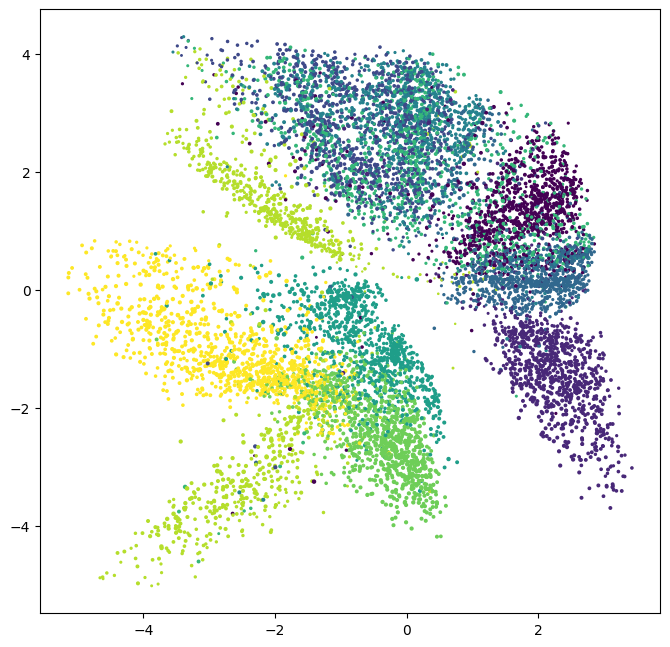

In [ ]:
# visualize the latent space
params = get_params(opt_state)
encoder_params = params[0]

"""
==============================
TODO: Implementation required.
==============================
1. Visualize the latent space of the trained VAE.
"""

raise NotImplementedError("Task: Implement!")

Monitor the reconstruction quality of your model. Visualize a single input image together its reconstruction.

Text(0.5, 1.0, 'reconstructed image')

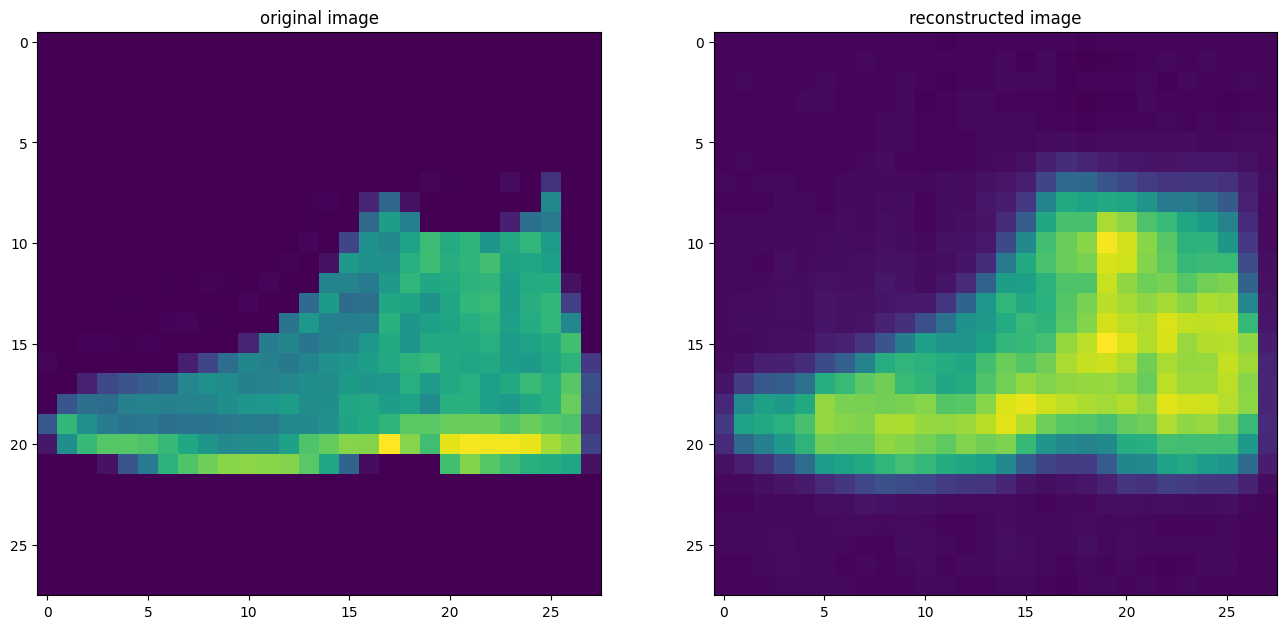

In [ ]:
"""
==============================
TODO: Implementation required.
==============================
1. Visualize a single input image together with its reconstruction.
"""

raise NotImplementedError("Task: Implement!")

**Generate synthetic data.** Hint: sample $z\sim p(z)$ or "walk" in the latent space. Decode the $z$ you sample/visit and plot the decoded image. Think about what output you expect when you sample from 1) a Beta distribution, or 2) regard the Beta parameters as the sample.

In [ ]:
@jit
def sample_imgs(z_rng, decoder_params):
    """
    ==============================
    TODO: Implementation required.
    ==============================
    1. Either sample from the prior, or walk/do a grid search over z's.
    """

    raise NotImplementedError("Task: Implement!")

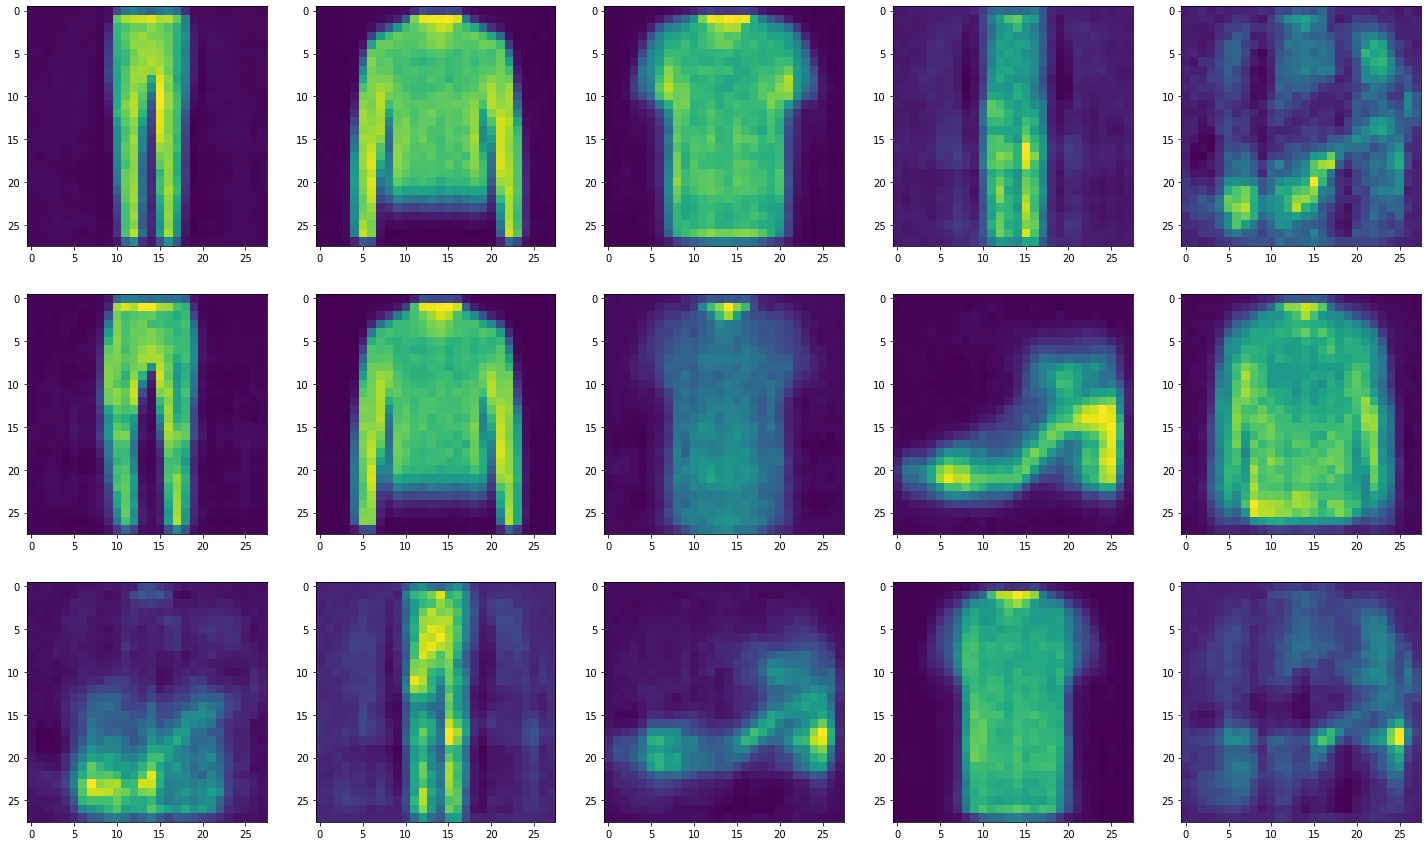

In [ ]:
params = get_params(opt_state)
decoder_params = params[1]
sampled_imgs = sample_imgs(test_key, decoder_params)

"""
==============================
TODO: Implementation required.
==============================
1. Visualize the sampled images
"""
    
raise NotImplementedError("Task: Implement!")

Finally it is valuable for us to know how long did it take you to finish this practical?